In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Titanic Survival Predictive Analysis**

The purpose of this analysis is to find out the change in classification accuracy of logistic regression with k-cross (k from 2 to 5) validation and penalty of ridge regression in the titanic dataset.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

## **Data Exploration**

Before going into the predictive analysis, let's do some exploration of the data. The data was imported as a dataframe and the info() and isnull() methods show missing values for the variables Age, Cabin, and Embarked.

In [3]:
titanic = pd.read_csv('/content/drive/MyDrive/PDD - Data Analytics/3 - Summer 2022/CPSC 4830/week-1/code/titanic_train.csv')

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

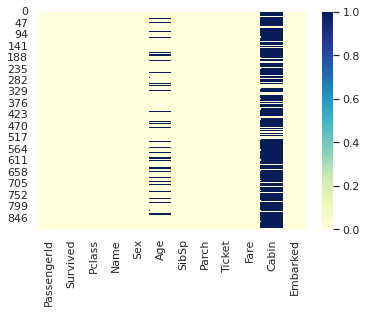

In [7]:
sns.heatmap(titanic.isnull(),cmap='YlGnBu')

In [8]:
print("Age feature has around {} percent missing values.".format(round((titanic['Age'].isnull().sum()/len(titanic['Age'])*100))))

Age feature has around 20 percent missing values.


In [9]:
print("Cabin feature has around {} percent missing values.".format(round((titanic['Cabin'].isnull().sum()/len(titanic['Cabin'])*100))))

Cabin feature has around 77 percent missing values.


In [10]:
print("Cabin feature has around {} percent missing values.".format(round((titanic['Embarked'].isnull().sum()/len(titanic['Embarked'])*100),2)))

Cabin feature has around 0.22 percent missing values.


### Data Cleaning

Before going any further, we need to deal with the missing data. Age is missing about 20% of the data. This is valuable information which means we can't directly delete the observations where age is missing. In this case, we can impute age values with the median depending on whether or not the passenger survived, their class and their sex. The boxplots below show that there's a difference (though in some cases minimal) between the median ages for each category of the features mentioned.

In [11]:
import matplotlib.pyplot as plt

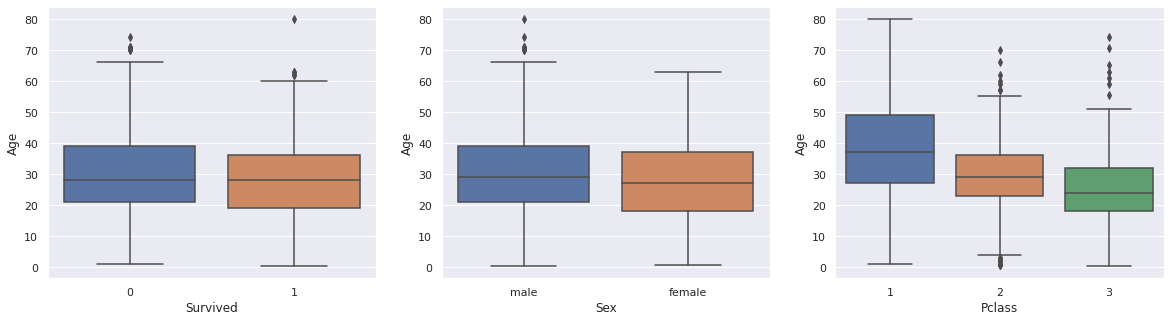

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5)) 
sns.boxplot(x="Survived", y="Age", data=titanic,ax = axes[0])
sns.boxplot(x="Sex", y="Age", data=titanic,ax = axes[1])
sns.boxplot(x="Pclass", y="Age", data=titanic,ax = axes[2])

In [13]:
titanic.groupby(["Pclass"])['Age'].median()

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [14]:
titanic.groupby(["Sex"])['Age'].median()

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

In [15]:
titanic.groupby(["Survived"])['Age'].median()

Survived
0    28.0
1    28.0
Name: Age, dtype: float64

Furthermore, the table below explains the mapping and the values that will be imputed into the age missing values.

In [16]:
titanic.groupby(["Survived","Sex","Pclass"])['Age'].median()

Survived  Sex     Pclass
0         female  1         25.0
                  2         32.5
                  3         22.0
          male    1         45.5
                  2         30.5
                  3         25.0
1         female  1         35.0
                  2         28.0
                  3         19.0
          male    1         36.0
                  2          3.0
                  3         25.0
Name: Age, dtype: float64

It seemed a little odd that the median age of passengers that survived, were male and from class 2 is 3 years old. However, the table below shows that the passengers with those features are indeed mostly children.

In [17]:
titanic[(titanic['Survived']==1) & (titanic['Sex']=='male') & (titanic['Pclass']==2)]['Age']

17       NaN
21     34.00
78      0.83
183     1.00
193     3.00
226    19.00
288    42.00
340     2.00
407     3.00
543    32.00
547      NaN
549     8.00
570    62.00
673    31.00
755     0.67
827     1.00
831     0.83
Name: Age, dtype: float64

In [18]:
titanic['Age'] = titanic['Age'].fillna(titanic.groupby(["Survived","Sex","Pclass"])['Age'].transform('median'))

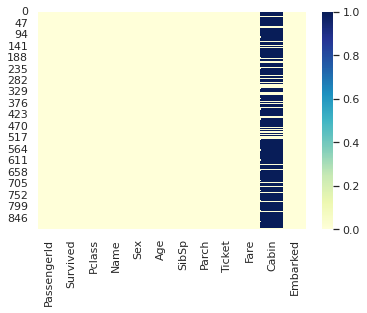

In [19]:
sns.heatmap(titanic.isnull(),cmap='YlGnBu')

As for the cabin, since 77% of observations are missing values, this can not be imputed. However, we can turn this feature into a dummy variable for cabin known.

In [20]:
titanic['Cabin'] = titanic['Cabin'].fillna(0)

In [21]:
titanic['Cabin'][titanic['Cabin']!=0]=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


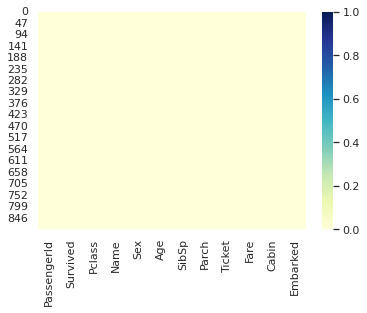

In [22]:
sns.heatmap(titanic.isnull(),cmap='YlGnBu')

As for Embarked, it's only missing 0.22% values, so these values can be dropped from the data.

In [23]:
titanic.dropna(axis=0, inplace=True)

Additionally, let's see if we can extract the title from the name for later use as a feature in our model.

In [24]:
titanic['title'] = titanic['Name'].str.extract(",\s(\S*)")

In [25]:
titanic.groupby('title').size()

title
Capt.          1
Col.           2
Don.           1
Dr.            7
Jonkheer.      1
Lady.          1
Major.         2
Master.       40
Miss.        181
Mlle.          2
Mme.           1
Mr.          517
Mrs.         124
Ms.            1
Rev.           6
Sir.           1
the            1
dtype: int64

As can be seen above, there are many titles that have a small quantity of passengers. These titles will be grouped into the title 'Other'.

In [26]:
titanic['title'][~((titanic['title']=='Master.') | 
                 (titanic['title']=='Miss.') |
                 (titanic['title']=='Mr.') |
                 (titanic['title']=='Mrs.'))] = 'Other'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [27]:
titanic.groupby('title').size()

title
Master.     40
Miss.      181
Mr.        517
Mrs.       124
Other       27
dtype: int64

Additionally, we know that the variables SibSp and Parch represent passengers traveling with siblings, spouses, parents or children. So we can combine these two variables and turn into a new variable that differentiates people traveling with family from people traveling alone.

In [28]:
# creating dummy for traveling with family
titanic['TravelFamily']=np.where((titanic["SibSp"]+titanic["Parch"])>0,1,0)
titanic.drop('SibSp',axis=1,inplace=True)
titanic.drop('Parch',axis=1,inplace=True)

In [29]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   889 non-null    int64  
 1   Survived      889 non-null    int64  
 2   Pclass        889 non-null    int64  
 3   Name          889 non-null    object 
 4   Sex           889 non-null    object 
 5   Age           889 non-null    float64
 6   Ticket        889 non-null    object 
 7   Fare          889 non-null    float64
 8   Cabin         889 non-null    object 
 9   Embarked      889 non-null    object 
 10  title         889 non-null    object 
 11  TravelFamily  889 non-null    int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 90.3+ KB


Now we have a clean dataset. Let's try to understand the relationship between each feature and the survival of the passenger.

### Survival Analysis

First, to see how the numerical features, Age and Fare, relate to Survival, let's plot histograms.

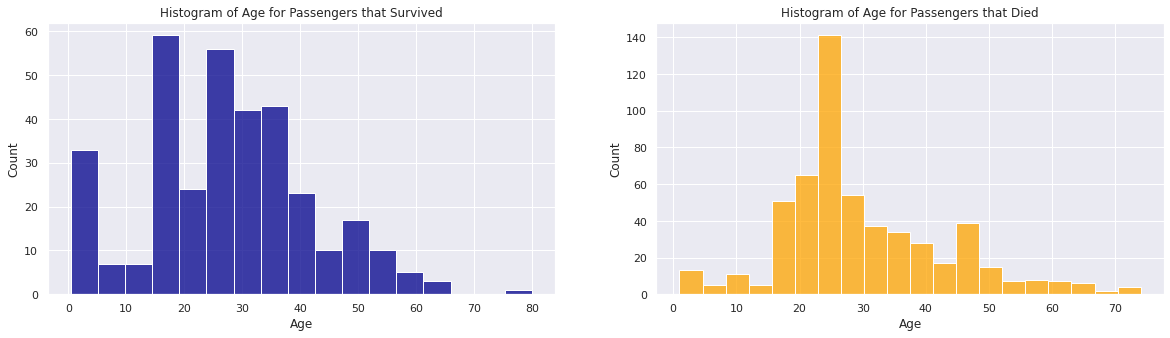

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5)) 
sns.histplot(titanic["Age"][titanic.Survived == 1], color="darkblue",ax = axes[0])
axes[0].title.set_text("Histogram of Age for Passengers that Survived")
sns.histplot(titanic["Age"][titanic.Survived == 0], color="orange",ax = axes[1])
axes[1].title.set_text("Histogram of Age for Passengers that Died")
plt.show()

The histograms show that from the passengers that survived, a larger proportion were children (note the blue peak around 0 years old). From the passengers that died, a larger proportion were young adults (note the orange peak around 20-25 years old). Apart from this, the distributions look similar.

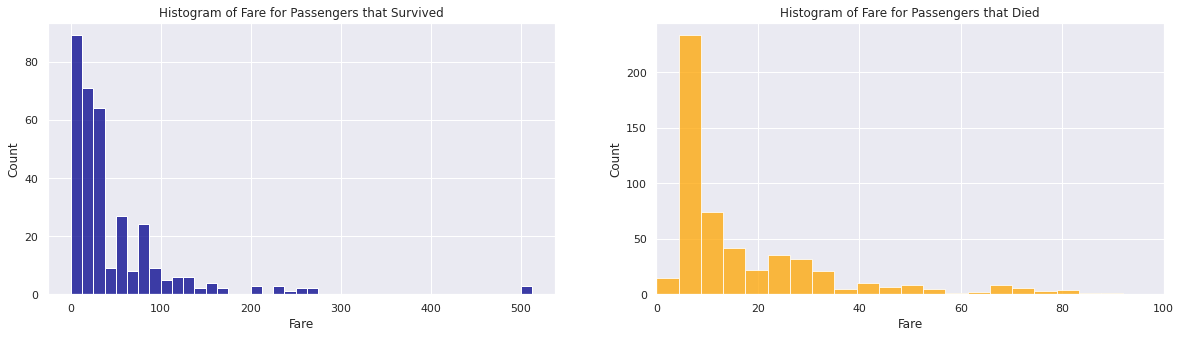

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5)) 
sns.histplot(titanic["Fare"][titanic.Survived == 1], color="darkblue",ax = axes[0])
axes[0].title.set_text("Histogram of Fare for Passengers that Survived")
sns.histplot(titanic["Fare"][titanic.Survived == 0], color="orange",ax = axes[1])
axes[1].title.set_text("Histogram of Fare for Passengers that Died")
plt.xlim(0,100)
plt.show()

As for Fare, the histograms show that for the passengers that died, a larger proportion of the passengers that died paid a low fare for their ticket.

Now, let's see how the categorical features relate to survival.

In [32]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'title', 'TravelFamily'],
      dtype='object')

In [33]:
cat_columns = ['Survived', 'Cabin','Pclass', 'TravelFamily', 'Sex', 'Embarked', 'title']

First, let's visualize survival along the rest of the categorical variables.

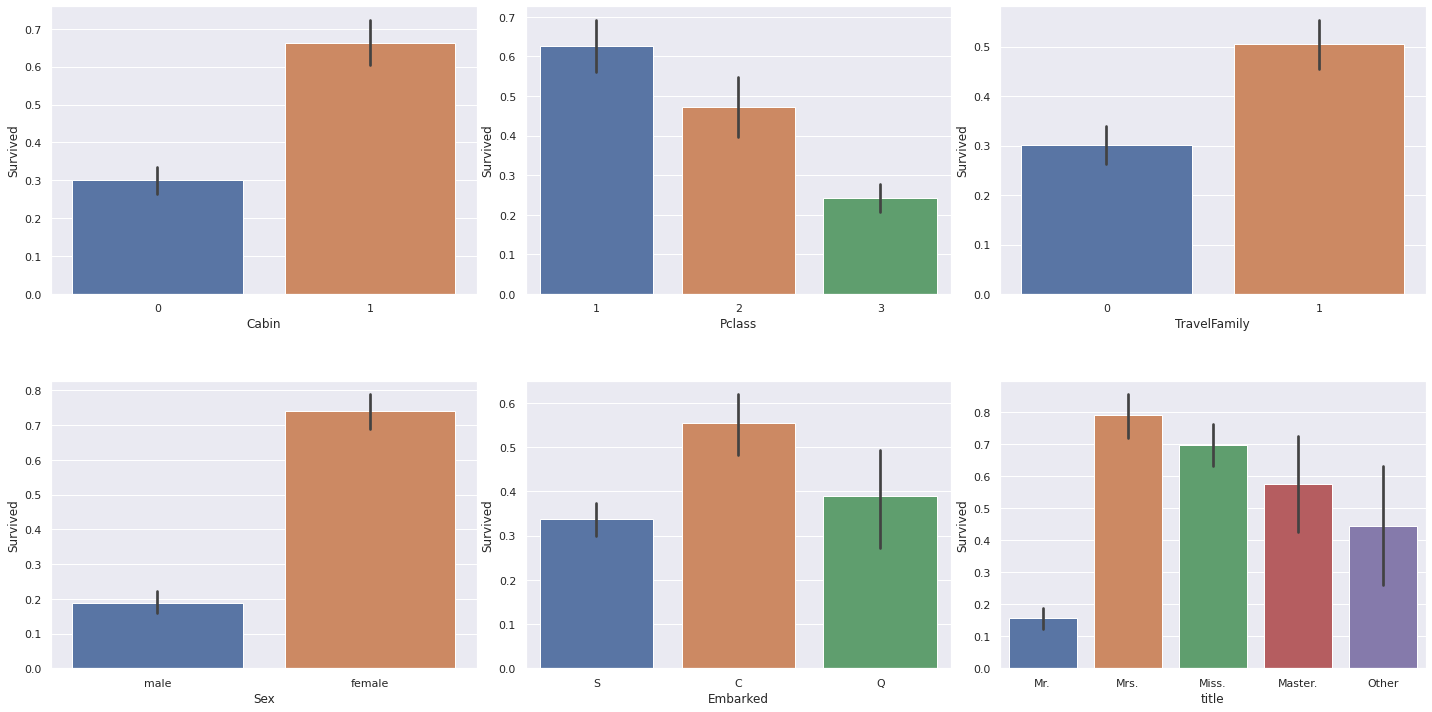

In [34]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
axs = axs.flatten()
for i,column in enumerate(cat_columns[1:]):
  sns.barplot(y=titanic['Survived'], x=titanic[column], ax=axs[i])
plt.tight_layout(w_pad = 0.5, h_pad=5.0)
#sns.barplot('Pclass','Survived', data=titanic, color="darkblue")

As can be seen in the bar plots above, people for which the cabin is known, first class passengers, passengers with family onboard, females were most likely to survive. Additionally, let's perform chi-squared test to see if survival is independent of the rest of categorical features or not. The features that are not independent will be included in the model.

In [35]:
from scipy.stats import chi2_contingency

In [36]:
for i in cat_columns[1:]:
  crosstab = pd.crosstab(titanic['Survived'],titanic[i])
  if chi2_contingency(crosstab)[1] < 0.05:
    # print(crosstab)
    print("Survived and {} are not independent.".format(i))

Survived and Cabin are not independent.
Survived and Pclass are not independent.
Survived and TravelFamily are not independent.
Survived and Sex are not independent.
Survived and Embarked are not independent.
Survived and title are not independent.


## **Data Preparation**

Now, to be able to use the categorical variables as features for our model. Let's create dummies for Sex, Pclass, Embarked, and title.

In [37]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,title,TravelFamily
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,0,S,Mr.,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,1,C,Mrs.,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,0,S,Miss.,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,1,S,Mrs.,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,0,S,Mr.,0


In [38]:
sex = pd.get_dummies(titanic['Sex'], drop_first=True)

In [39]:
pclass = pd.get_dummies(titanic['Pclass'], prefix='Pclass', drop_first=True)

In [40]:
embarked = pd.get_dummies(titanic['Embarked'], drop_first=True)

In [41]:
title = pd.get_dummies(titanic['title'], drop_first=True)

Before adding the new dummies to our dataframe, let's drop the other variables including those we're not going to use, as name, ticket and passengerId.

In [42]:
titanic.drop(['Sex', 'Embarked','Name','Ticket','title','PassengerId','Pclass'], axis=1, inplace=True)

In [43]:
titanic.head()

,Survived,Age,Fare,Cabin,TravelFamily
0,0,22.0,7.2500,0,1
1,1,38.0,71.2833,1,1
2,1,26.0,7.9250,0,0
3,1,35.0,53.1000,1,1
4,0,35.0,8.0500,0,0


In [44]:
titanic = pd.concat([titanic,sex,embarked,title,pclass], axis=1)

In [45]:
titanic.head()

,Survived,Age,Fare,Cabin,TravelFamily,male,Q,S,Miss.,Mr.,Mrs.,Other,Pclass_2,Pclass_3
0,0,22.0,7.2500,0,1,1,0,1,0,1,0,0,0,1
1,1,38.0,71.2833,1,1,0,0,0,0,0,1,0,0,0
2,1,26.0,7.9250,0,0,0,0,1,1,0,0,0,0,1
3,1,35.0,53.1000,1,1,0,0,1,0,0,1,0,0,0
4,0,35.0,8.0500,0,0,1,0,1,0,1,0,0,0,1


## **Model Training**

Before going further with the logistic model, let's split our data into training and testing.

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(titanic.drop('Survived',axis=1), 
                                                    titanic['Survived'], 
                                                    test_size=0.30, 
                                                    random_state=101)

In [48]:
X_train

,Age,Fare,Cabin,TravelFamily,male,Q,S,Miss.,Mr.,Mrs.,Other,Pclass_2,Pclass_3
807,18.0,7.7750,0,0,0,0,1,1,0,0,0,0,1
651,18.0,23.0000,0,1,0,0,1,1,0,0,0,1,0
2,26.0,7.9250,0,0,0,0,1,1,0,0,0,0,1
690,31.0,57.0000,1,1,1,0,1,0,1,0,0,0,0
196,25.0,7.7500,0,0,1,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,34.0,13.0000,0,0,0,0,1,1,0,0,0,1,0
840,20.0,7.9250,0,0,1,0,1,0,1,0,0,0,1
338,45.0,8.0500,0,0,1,0,1,0,1,0,0,0,1
524,25.0,7.2292,0,0,1,0,0,0,1,0,0,0,1


In [49]:
y_train

807    0
651    1
2      1
690    1
196    0
      ..
576    1
840    0
338    1
524    0
865    1
Name: Survived, Length: 622, dtype: int64

Now, since we want to see the change in accuracy when we apply cross validation with k from 2 to 5, let's save our results in a dictionary.

In [50]:
from sklearn.linear_model import LogisticRegressionCV
from numpy import arange

In [51]:
from sklearn.metrics import classification_report

Using LogisticRegressionCV, let's build a loop for k from 2 to 5, and penalty 'l2' to specify ridge regression. The C hyperparameter is the inverse of the regularization strength. To the LogisticRegressionCV I have passed a list of numbers from 0.0001 to 10, the attribute C_ returns the best C from that list for each split. The function also chooses the best estimator from the different splits to make predictions. Below are the results of classification report for each k.

In [52]:
# for k from 2 to 5
results = {
           'Cs':{}}
predictions = {}
for i in arange(2,6,1):
  logmodel = LogisticRegressionCV(Cs=arange(0.0001,10,0.01), cv=i, penalty='l2', max_iter=500)
  logmodel.fit(X_train,y_train)
  #results['Scores'][i] = logmodel.scores_
  results['Cs'][i] = logmodel.C_
  predictions[i] = logmodel.predict(X_test)
  print("----------------------------------------------------------")
  print("Classification Report for the decision function with k={}: \n{}\n".format(i,classification_report(y_test,predictions[i])))
  print("----------------------------------------------------------")

----------------------------------------------------------
Classification Report for the decision function with k=2: 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       163
           1       0.82      0.72      0.77       104

    accuracy                           0.83       267
   macro avg       0.82      0.81      0.81       267
weighted avg       0.83      0.83      0.83       267


----------------------------------------------------------
----------------------------------------------------------
Classification Report for the decision function with k=3: 
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       163
           1       0.84      0.71      0.77       104

    accuracy                           0.84       267
   macro avg       0.84      0.81      0.82       267
weighted avg       0.84      0.84      0.83       267


-------------------------------------------------

In [53]:
results

{'Cs': {2: array([5.5801]),
  3: array([0.4401]),
  4: array([2.1201]),
  5: array([5.1201])}}

From the output above, there's not much difference in choosing k between 2 and 5. As the decision function chosen from the different splits for each k results in the accuracyof 83%-84% for all ks.

Let's use cross_validate to see how the result changes for each split across different ks. We know from the result above the best C for each split.

In [54]:
# for k from 2 to 5
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics

In [55]:
results = {'Acccuracy':{},
           'Precision':{},
           'Recall':{},
           'Estimator':{}}
predictions = {}
for i in arange(2,6,1):
  for c in [5.5801,0.4401,2.1201,5.1201]:
    logmodel = LogisticRegression(C=c, penalty='l2', max_iter=600)
    cv_lg = cross_validate(logmodel,X_train,y_train, cv=i, scoring = ['accuracy','precision','recall'], return_estimator=True)
    results['Acccuracy'][i] = cv_lg['test_accuracy']
    results['Precision'][i] = cv_lg['test_precision']
    results['Recall'][i] = cv_lg['test_recall']
    results['Estimator'][i] = cv_lg['estimator']
  index = 1
  for item in cv_lg['estimator']:
    y_hat = item.predict(X_test)
    print("----------------------------------------------------------")
    print("\n Classification Report for split {} with k={}: \n\n{}".format(index,i,classification_report(y_test,y_hat)))
    acc = metrics.accuracy_score(y_test,y_hat)
    prec = metrics.precision_score(y_test,y_hat)
    rec = metrics.recall_score(y_test,y_hat)
    print("Accuracy = {}\nPrecision = {}\nRecall = {}".format(acc,prec,rec))
    print("----------------------------------------------------------")
    index += 1

----------------------------------------------------------

 Classification Report for split 1 with k=2: 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       163
           1       0.81      0.75      0.78       104

    accuracy                           0.84       267
   macro avg       0.83      0.82      0.82       267
weighted avg       0.83      0.84      0.83       267

Accuracy = 0.8352059925093633
Precision = 0.8125
Recall = 0.75
----------------------------------------------------------
----------------------------------------------------------

 Classification Report for split 2 with k=2: 

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       163
           1       0.90      0.63      0.75       104

    accuracy                           0.83       267
   macro avg       0.85      0.80      0.81       267
weighted avg       0.84      0.83      0.82       267

Accuracy =

The results above show the classification report for each split across all ks. We can see that still there's not much difference from the previous results. Out of the total, the models accurately predicts 83%-85% outputs (whether died or survived). From the passengers predicted as survived, 81%-90% were correctly predicted. From the passengers that actually survived, 63%-76% were correctly predicted as survivors. 

If we look only for accuracy, there's not much difference in cross validating with ks from 2 to 5. All splits across the different ks have pretty similar accuracies. If we look to answer other questions, such as:

1. From the passengers that our model predicted as survivors, what percentage actually survived? We should choose the model from split 3 with k=3, which has the highest precision on 90%.

2. From the passengers that actually survived, what percentage did our model correctly predict? We should choose the model from split 1 with k=5, which has the highest recall on 76%.